In [1]:
import pandas as pd

import os
for dirname, _, filenames in os.walk('dataset/updated_final_dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

dataset/updated_final_dataset/._SUCCESS.crc
dataset/updated_final_dataset/.part-00000-aa676cdb-8c51-4d6d-bf5c-769e9b44f214-c000.csv.crc
dataset/updated_final_dataset/_SUCCESS
dataset/updated_final_dataset/part-00000-aa676cdb-8c51-4d6d-bf5c-769e9b44f214-c000.csv


In [2]:


# Load the dataset provided by the user
file_path = 'dataset/updated_final_dataset/part-00000-aa676cdb-8c51-4d6d-bf5c-769e9b44f214-c000.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
df.head()


,StartTime(UTC),EndTime(UTC),Severity,Precipitation(in),AirportCode,LocationLat,LocationLng,City,State,Broad_Weather_Condition
0,2022-12-31T23:55:00.000-06:00,2022-12-31T23:56:00.000-06:00,Light,0.01,KGTB,44.0556,-75.7195,Fort Drum,NY,rainy
1,2022-12-31T23:44:00.000-06:00,2022-12-31T23:56:00.000-06:00,Light,0.00,KSLI,33.7963,-118.0418,Los Alamitos,CA,rainy
2,2022-12-31T23:44:00.000-06:00,2022-12-31T23:56:00.000-06:00,Heavy,0.95,KAKQ,36.9827,-77.0014,Wakefield,VA,rainy
3,2022-12-31T23:43:00.000-06:00,2022-12-31T23:59:00.000-06:00,Moderate,0.22,KSJC,37.3594,-121.9244,San Jose,CA,rainy
4,2022-12-31T23:43:00.000-06:00,2022-12-31T23:54:00.000-06:00,Light,0.02,KBWI,39.1733,-76.6840,Baltimore,MD,rainy


In [3]:
from sklearn.model_selection import train_test_split

# Since you are working with pandas, sklearn's train_test_split is more appropriate than randomSplit

MAX_TRAIN_SIZE = 999_999

# Perform the train-test split (80% train, 20% test) using sklearn
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Apply the limit due to constraints
train_df = train_df[:MAX_TRAIN_SIZE]

# Output the size of train and test sets
print(f'Train set size:  {len(train_df)} instances')
print(f'Test set size:   {len(test_df)} instances')


Train set size:  34336 instances
Test set size:   8585 instances


In [4]:
from pyspark.sql import SparkSession

# Initialize SparkSession with memory configurations
spark = SparkSession.builder \
    .appName("Weather Clustering Model") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# 将 Pandas DataFrame 转换为 PySpark DataFrame
train_spark_df = spark.createDataFrame(train_df)
test_spark_df = spark.createDataFrame(test_df)

# Define the columns for numerical and categorical features
NUMERICAL_FEATURES = [
    'Precipitation(in)',   # Precipitation level
    'LocationLat',         # Latitude
    'LocationLng'          # Longitude
]

CATEGORICAL_FEATURES = [
    'Severity',            # Severity of the weather (categorical)
    'AirportCode',         # Airport code (categorical)
    'City',                # City name
    'State'                # State name
]

TARGET_VARIABLE_COL = 'Broad_Weather_Condition'  # This is the target column we are predicting
PREDICTED_TARGET_VARIABLE_COL = f'predicted_{TARGET_VARIABLE_COL}'  # Predicted target column

LABEL_COL = 'label'  # Label column for the ML model
PREDICTION_COL = 'prediction'  # Prediction column for the ML model

FEATURES_COL = 'features'  # Features column for the ML model
SCALED_FEATURES_COL = f'scaled_{FEATURES_COL}'  # Scaled features column for the ML model

# 训练模型之前，通常需要将分类特征进行编码，将数值特征标准化
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler

# StringIndexing categorical features
indexers = [
    StringIndexer(inputCol=column, outputCol=f'{column}_indexed', handleInvalid="keep") 
    for column in CATEGORICAL_FEATURES
]

# StringIndexing the target variable
label_indexer = StringIndexer(inputCol=TARGET_VARIABLE_COL, outputCol=LABEL_COL)

# OneHotEncode the indexed categorical features
encoders = [
    OneHotEncoder(inputCol=f'{column}_indexed', outputCol=f'{column}_encoded') 
    for column in CATEGORICAL_FEATURES
]

# Assemble numerical and categorical features into a single feature vector
assembler = VectorAssembler(
    inputCols=[f'{column}_encoded' for column in CATEGORICAL_FEATURES] + NUMERICAL_FEATURES, 
    outputCol=FEATURES_COL
)

# Scale the features
scaler = StandardScaler(inputCol=FEATURES_COL, outputCol=SCALED_FEATURES_COL)

# Create a pipeline with the label indexer included
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, label_indexer])

# Apply the pipeline to the training data (now PySpark DataFrame)
train_data_transformed = pipeline.fit(train_spark_df).transform(train_spark_df)

# Now, you can use the transformed data to train your model (e.g., DecisionTree, RandomForest, etc.)
from pyspark.ml.classification import DecisionTreeClassifier

# Define the classifier
dt_classifier = DecisionTreeClassifier(labelCol=LABEL_COL, featuresCol=SCALED_FEATURES_COL)

# Train the model
model = dt_classifier.fit(train_data_transformed)

# Function to save PySpark model
def save_pyspark_model(model, path: str, append_datetime: bool = True) -> None:
    """
    Save a PySpark model to a specified path. Optionally append the current datetime to the path.
    
    Parameters:
    model (pyspark.ml.Model): The PySpark model to be saved.
    path (str): The directory path where the model will be saved.
    append_datetime (bool): If True, append the current datetime to the path (default is True).
    """
    if append_datetime:
        from datetime import datetime
        # Append current date and time to the path in format: YYYYDDMM-HHMMSS
        path += '-' + datetime.now().strftime("%Y%d%m-%H%M%S")
    
    try:
        # Save the model to the specified path, overwriting any existing files
        model.write().overwrite().save(path)
        print(f"Model successfully saved to: {path}")
    except Exception as e:
        print(f"An error occurred while saving the model: {e}")

# Save the trained model
save_pyspark_model(model, path="models/my_decision_tree_model")

# 对测试数据进行同样的预处理
test_data_transformed = pipeline.fit(train_spark_df).transform(test_spark_df)

# 用模型进行预测
predictions = model.transform(test_data_transformed)



24/09/27 13:27:59 WARN Utils: Your hostname, CHIVEs-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.44 instead (on interface en0)
24/09/27 13:27:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/27 13:28:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Model successfully saved to: models/my_decision_tree_model-20242709-132839


In [5]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql import DataFrame
from pyspark.ml.pipeline import PipelineModel
from typing import List

# 定义常量：标签列、特征列、缩放后的特征列
LABEL_COL = 'label'
FEATURES_COL = 'features'
SCALED_FEATURES_COL = 'scaled_features'

def encoding_pipeline(dataframe: DataFrame,
                      numerical_features: List[str],
                      categorical_features: List[str],
                      target_variable: str,
                      with_std: bool = True,
                      with_mean: bool = False) -> PipelineModel:

    # 1. 将目标列（如 Broad_Weather_Condition）进行索引，转化为数值，并作为标签列
    label_indexer = StringIndexer(inputCol=target_variable, outputCol=LABEL_COL)

    # 2. 对每一个类别特征进行索引
    indexers = [StringIndexer(inputCol=c, outputCol=f'{c}_indexed', handleInvalid='keep') for c in categorical_features]

    # 3. 对索引后的类别特征进行独热编码（one-hot encoding）
    encoder = OneHotEncoder(inputCols=[f'{c}_indexed' for c in categorical_features], 
                            outputCols=[f'{c}_encoded' for c in categorical_features], 
                            handleInvalid='keep')

    # 4. 将所有独热编码的类别特征和数值特征组合为一个特征向量
    features = [f'{c}_encoded' for c in categorical_features] + numerical_features
    assembler = VectorAssembler(inputCols=features, outputCol=FEATURES_COL)

    # 5. 对组合后的特征向量进行标准化
    scaler = StandardScaler(inputCol=FEATURES_COL, outputCol=SCALED_FEATURES_COL, withStd=with_std, withMean=with_mean)

    # 6. 构建管道，将所有步骤（索引、编码、组合、标准化）作为阶段添加
    stages = [label_indexer] + indexers + [encoder] + [assembler] + [scaler]
    pipeline = Pipeline(stages=stages)

    # 7. 训练管道并返回 transformer，用于转换训练集和测试集
    transformer = pipeline.fit(dataframe)

    return transformer

# 示例：将训练数据和测试数据通过预处理管道转换并保存
train_spark_df = spark.createDataFrame(train_df)
test_spark_df = spark.createDataFrame(test_df)

# 定义数值特征和类别特征
numerical_features = ['Precipitation(in)', 'LocationLat', 'LocationLng']
categorical_features = ['Severity', 'AirportCode', 'City', 'State']
target_variable = 'Broad_Weather_Condition'

# 使用 encoding_pipeline 创建并应用到训练集和测试集
pipeline_model = encoding_pipeline(train_spark_df, numerical_features, categorical_features, target_variable)

# 对训练数据和测试数据应用转换
train_data_transformed = pipeline_model.transform(train_spark_df)
test_data_transformed = pipeline_model.transform(test_spark_df)

# 保存训练好的管道模型
pipeline_model.write().overwrite().save("models/saved_encoding_pipeline_model")

# 保存转换后的数据集
train_data_transformed.write.mode('overwrite').parquet('data/train_transformed.parquet')
test_data_transformed.write.mode('overwrite').parquet('data/test_transformed.parquet')




24/09/27 13:28:59 WARN DAGScheduler: Broadcasting large task binary with size 1187.3 KiB
24/09/27 13:29:02 WARN DAGScheduler: Broadcasting large task binary with size 1187.3 KiB


In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql import DataFrame
from pyspark.ml.pipeline import PipelineModel
from typing import List

# 定义常量：标签列、特征列、缩放后的特征列
LABEL_COL = 'label'
FEATURES_COL = 'features'
SCALED_FEATURES_COL = 'scaled_features'

# 定义保存模型的函数
def save_pyspark_model(model, path: str, append_datetime: bool = True) -> None:
    """
    Save a PySpark model to a specified path. Optionally append the current datetime to the path.
    
    Parameters:
    model (pyspark.ml.Model): The PySpark model to be saved.
    path (str): The directory path where the model will be saved.
    append_datetime (bool): If True, append the current datetime to the path (default is True).
    """
    if append_datetime:
        from datetime import datetime
        # Append current date and time to the path in format: YYYYDDMM-HHMMSS
        path += '-' + datetime.now().strftime("%Y%d%m-%H%M%S")
    
    try:
        # Save the model to the specified path, overwriting any existing files
        model.write().overwrite().save(path)
        print(f"Model successfully saved to: {path}")
    except Exception as e:
        print(f"An error occurred while saving the model: {e}")

# 编码管道构建函数
def encoding_pipeline(dataframe: DataFrame,
                      numerical_features: List[str],
                      categorical_features: List[str],
                      target_variable: str,
                      with_std: bool = True,
                      with_mean: bool = False) -> (PipelineModel, List[str]):
    """
    构建用于对数据集进行编码的管道，并提取 StringIndexer 的标签.
    
    参数:
    - dataframe: 输入数据集
    - numerical_features: 数值特征列
    - categorical_features: 类别特征列
    - target_variable: 目标变量
    - with_std: 是否进行标准化
    - with_mean: 是否均值归一化

    返回:
    - PipelineModel: 训练好的编码管道模型
    - List[str]: 目标变量 StringIndexer 提取的标签
    """

    # 将目标列（如 Broad_Weather_Condition）进行索引，转化为数值，并作为标签列
    label_indexer = StringIndexer(inputCol=target_variable, outputCol=LABEL_COL)

    # 对每一个类别特征进行索引
    indexers = [StringIndexer(inputCol=c, outputCol=f'{c}_indexed', handleInvalid='keep') for c in categorical_features]

    # 对索引后的类别特征进行独热编码（one-hot encoding）
    encoder = OneHotEncoder(inputCols=[f'{c}_indexed' for c in categorical_features], 
                            outputCols=[f'{c}_encoded' for c in categorical_features], 
                            handleInvalid='keep')

    # 将所有独热编码的类别特征和数值特征组合为一个特征向量
    features = [f'{c}_encoded' for c in categorical_features] + numerical_features
    assembler = VectorAssembler(inputCols=features, outputCol=FEATURES_COL)

    # 对组合后的特征向量进行标准化
    scaler = StandardScaler(inputCol=FEATURES_COL, outputCol=SCALED_FEATURES_COL, withStd=with_std, withMean=with_mean)

    # 构建管道，将所有步骤（索引、编码、组合、标准化）作为阶段添加
    stages = [label_indexer] + indexers + [encoder] + [assembler] + [scaler]
    pipeline = Pipeline(stages=stages)

    # 训练管道
    transformer = pipeline.fit(dataframe)

    # 提取目标变量 StringIndexer 的标签
    label_indexer_model = transformer.stages[0]  # 目标列的 StringIndexer 是第一个 stage
    labels = label_indexer_model.labels

    return transformer, labels

# ===========================
# 主流程：训练编码管道并保存模型
# ===========================

# 假设你已经有了 train_spark_df, test_spark_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE_COL

# 训练编码管道，并提取目标列的标签
data_encoder, string_indexer_labels = encoding_pipeline(train_spark_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE_COL)

# 打印 StringIndexer 提取的标签
print(f"StringIndexer 提取的标签: {string_indexer_labels}")

# 定义保存路径
MODELS_PATH: str = 'models'
ENCODING_PIPELINE_PATH: str = f'{MODELS_PATH}/data_encoder'

# 保存编码模型
save_pyspark_model(data_encoder, ENCODING_PIPELINE_PATH)

# 将编码后的管道应用于训练和测试数据集
encoded_train_df = data_encoder.transform(train_spark_df)
encoded_test_df = data_encoder.transform(test_spark_df)

# 查看训练数据集中的前5行，显示特征列、缩放后的特征列和标签列
encoded_train_df.select([FEATURES_COL, SCALED_FEATURES_COL, LABEL_COL]).show(5)


StringIndexer 提取的标签: ['cold', 'snowy', 'foggy', 'rainy', 'hail']
Model successfully saved to: models/data_encoder-20242709-132906
+--------------------+--------------------+-----+
|            features|     scaled_features|label|
+--------------------+--------------------+-----+
|(3640,[0,15,1973,...|(3640,[0,15,1973,...|  0.0|
|(3640,[1,1257,310...|(3640,[1,1257,310...|  1.0|
|(3640,[1,1237,306...|(3640,[1,1237,306...|  1.0|
|(3640,[1,124,2105...|(3640,[1,124,2105...|  3.0|
|(3640,[0,641,2607...|(3640,[0,641,2607...|  0.0|
+--------------------+--------------------+-----+
only showing top 5 rows



In [7]:
## Random Forest Model

In [8]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.feature import IndexToString

# 初始化 SparkSession，增加内存配置
spark = SparkSession.builder \
    .appName("Weather Clustering Model") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

# 定义模型保存路径
RANDOM_FOREST_MODEL_PATH = "models/random_forest_model"

# 手动定义是否加载预训练模型
LOAD_PRETRAINED_MODELS = False  # 设置为 True 时加载预训练模型，设置为 False 时重新训练

# 检查是否加载预训练模型或训练新的模型
if LOAD_PRETRAINED_MODELS:
    # 加载预训练的 Random Forest 模型
    rnd_forest_model = RandomForestClassificationModel.load(RANDOM_FOREST_MODEL_PATH)
else:
    # 训练新的 Random Forest 模型
    rnd_forest_model = RandomForestClassifier(featuresCol=FEATURES_COL, labelCol=LABEL_COL).fit(encoded_train_df)
    # 保存训练好的模型
    rnd_forest_model.write().overwrite().save(RANDOM_FOREST_MODEL_PATH)

# 对训练和测试数据集减少分区，优化内存使用
encoded_train_df = encoded_train_df.repartition(4)
encoded_test_df = encoded_test_df.repartition(4)

# 使用模型对测试集进行预测
rnd_forest_predictions = rnd_forest_model.transform(encoded_test_df)

# 使用 IndexToString 将预测的索引转化为原始标签
predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                       outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                       labels=data_encoder.stages[0].labels)

# 将索引转换为原始的目标变量标签
rnd_forest_predictions = predictions_idx_to_str.transform(rnd_forest_predictions)

# 展示预测结果的前5行
rnd_forest_predictions.select(PREDICTED_TARGET_VARIABLE_COL, PREDICTION_COL, LABEL_COL).show(5)

# 释放内存
encoded_train_df.unpersist()
encoded_test_df.unpersist()



24/09/27 13:29:10 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+---------------------------------+----------+-----+
|predicted_Broad_Weather_Condition|prediction|label|
+---------------------------------+----------+-----+
|                            snowy|       1.0|  1.0|
|                             cold|       0.0|  0.0|
|                            rainy|       3.0|  3.0|
|                            rainy|       3.0|  3.0|
|                            snowy|       1.0|  1.0|
+---------------------------------+----------+-----+
only showing top 5 rows



DataFrame[StartTime(UTC): string, EndTime(UTC): string, Severity: string, Precipitation(in): double, AirportCode: string, LocationLat: double, LocationLng: double, City: string, State: string, Broad_Weather_Condition: string, label: double, Severity_indexed: double, AirportCode_indexed: double, City_indexed: double, State_indexed: double, Severity_encoded: vector, AirportCode_encoded: vector, City_encoded: vector, State_encoded: vector, features: vector, scaled_features: vector]

In [9]:
from pyspark.sql import DataFrame
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def eval_predictions(predictions: DataFrame) -> None:
    # 定义评估器：分别评估精确率、召回率和准确率
    precision_evaluator = MulticlassClassificationEvaluator(labelCol=LABEL_COL, predictionCol=PREDICTION_COL, metricName="weightedPrecision")
    recall_evaluator = MulticlassClassificationEvaluator(labelCol=LABEL_COL, predictionCol=PREDICTION_COL, metricName="weightedRecall")
    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol=LABEL_COL, predictionCol=PREDICTION_COL, metricName="accuracy")

    # 计算度量值
    precision = precision_evaluator.evaluate(predictions)
    recall = recall_evaluator.evaluate(predictions)
    accuracy = accuracy_evaluator.evaluate(predictions)
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

    # 打印评估结果
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1_score:.4f}')

# 调用评估函数，评估随机森林模型的预测结果
eval_predictions(rnd_forest_predictions)


Accuracy: 0.6834
Precision: 0.7153
Recall: 0.6834
F1-score: 0.6990


In [10]:
# 定义模型保存路径
RANDOM_FOREST_MODEL_PATH: str = f'{MODELS_PATH}/rnd_forest'

# 定义是否保存模型的变量
SAVE_COMPUTATIONS = True  # 如果需要保存模型，设为 True；如果不需要保存模型，设为 False
LOAD_PRETRAINED_MODELS = False  # 如果加载预训练模型，设为 True

# 保存模型的函数
def save_pyspark_model(model, path: str, append_datetime: bool = True) -> None:
    """
    保存 PySpark 模型到指定路径。可选地在路径末尾附加当前日期时间。

    参数:
    model (pyspark.ml.Model): 要保存的 PySpark 模型。
    path (str): 保存模型的目录路径。
    append_datetime (bool): 如果为 True，路径末尾会附加当前日期时间（默认值为 True）。
    """
    if append_datetime:
        from datetime import datetime
        # 在路径末尾附加当前的日期和时间，格式为 YYYYMMDD-HHMMSS
        path += '-' + datetime.now().strftime("%Y%m%d-%H%M%S")
    
    try:
        # 保存模型到指定路径，覆盖已存在的文件
        model.write().overwrite().save(path)
        print(f"Model successfully saved to: {path}")
    except Exception as e:
        print(f"An error occurred while saving the model: {e}")

# 检查是否需要保存模型（在非预训练模型情况下）
if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    # 调用保存模型函数
    save_pyspark_model(rnd_forest_model, RANDOM_FOREST_MODEL_PATH)
    print("Random Forest model saved")



Model successfully saved to: models/rnd_forest-20240927-132935
Random Forest model saved


Confusion matrix saved to: models/confusion_matrix.png


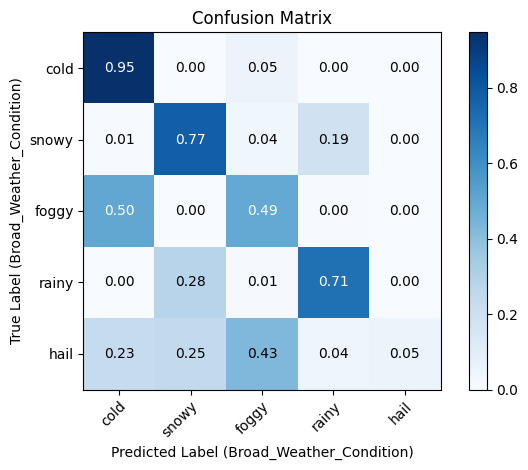

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os

# 定义混淆矩阵绘制函数
def plot_confusion_matrix(predictions_df: DataFrame,
                          target_col: str,
                          prediction_col: str,
                          true_labels: list,
                          pred_labels: list,
                          models_path: str,
                          normalize: bool = False,
                          title: str = None):
    
    # Compute confusion matrix components
    metrics_data = predictions_df.groupBy(target_col, prediction_col).count().collect()

    # 打印 Broad_Weather_Condition 对应的真实和预测标签
    #print(f"True Broad_Weather_Condition labels (y-axis): {true_labels}")
    #print(f"Predicted Broad_Weather_Condition labels (x-axis): {pred_labels}")

    # Initialize confusion matrix
    num_labels = max(len(true_labels), len(pred_labels))
    cm = np.zeros((num_labels, num_labels), dtype=int)

    # Create dictionaries that map index (encoded labels) to actual Broad_Weather_Condition names
    index_to_true_label = {i: label for i, label in enumerate(true_labels)}
    index_to_pred_label = {i: label for i, label in enumerate(pred_labels)}

    # Fill confusion matrix using numerical indices to map to Broad_Weather_Condition names
    for row in metrics_data:
        i = int(row[target_col])  # Get the index for the true label
        j = int(row[prediction_col])  # Get the index for the predicted label
        cm[i, j] = row['count']

    # Normalize if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrix
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # Replace the axis ticks with actual Broad_Weather_Condition labels
    ax.set(xticks=np.arange(num_labels),
           yticks=np.arange(num_labels),
           xticklabels=[index_to_pred_label[i] for i in range(num_labels)],  # Use predicted labels for x-axis
           yticklabels=[index_to_true_label[i] for i in range(num_labels)],  # Use true labels for y-axis
           title=title if title else 'Confusion Matrix',
           ylabel='True Label (Broad_Weather_Condition)',
           xlabel='Predicted Label (Broad_Weather_Condition)')

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(num_labels):
        for j in range(num_labels):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()

    # Save the plot to a file
    filename = os.path.join(models_path, "confusion_matrix.png")
    plt.savefig(filename)
    print(f"Confusion matrix saved to: {filename}")

    # Show the plot
    plt.show()

# 示例：绘制并保存混淆矩阵
true_labels = string_indexer_labels  # 从 StringIndexer 提取的真实标签
pred_labels = string_indexer_labels  # 预测标签（与真实标签相同）

plot_confusion_matrix(rnd_forest_predictions, 'label', PREDICTION_COL, true_labels, pred_labels, MODELS_PATH, normalize=True)

